In [7]:
# -*- coding: utf-8 -*-
"""
Created on Thu Apr  4 19:47:41 2019

@author: litha
"""

from sklearn.linear_model import LassoCV
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
from sklearn.model_selection import train_test_split 
from commonfunctions import *

path = "./data/"

filename_read = os.path.join(path,"iris.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

# create feature vector
###missing_median(df, 'horsepower')
###df.drop('name',1,inplace=True)
# Do not need zscore standardization for linear regression
#encode_numeric_zscore(df, 'horsepower')
#encode_numeric_zscore(df, 'weight')
#encode_numeric_zscore(df, 'cylinders')
#encode_numeric_zscore(df, 'displacement')
#encode_numeric_zscore(df, 'acceleration')
###encode_text_dummy(df, 'origin')
encode_text_index(df,'species')
df = df.drop(df[df.species == 0].index)
df.loc[df['species'] == 1, 'species'] = -1
df.loc[df['species'] == 2, 'species'] = 1
# Encode to a 2D matrix for training
x,y = to_xy(df,'species')
y = y[:,0]
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=45)


In [11]:
# -*- coding: utf-8 -*-
"""
Created on Thu Apr  4 19:37:22 2019

@author: litha
"""

import base64
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from sklearn import preprocessing

from IPython.display import display, HTML    

def report_coef(names,coef,intercept,title=""):
    r = pd.DataFrame( { 'coef': coef, 'positive': coef>=0  }, index = names )
    r = r.sort_values(by=['coef'])
    display(r)
    print("Intercept: {}".format(intercept))
    r['coef'].plot(kind='barh',title=title, color=r['positive'].map({True: 'b', False: 'r'}))
    
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = f"{name}-{tv}"
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(
        target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    # Regression
    return df[result].values.astype(np.float32), df[[target]].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"


# Regression chart.
def chart_regression(pred, y, sort=True):
    t = pd.DataFrame({'pred': pred, 'y': y.flatten()})
    if sort:
        t.sort_values(by=['y'], inplace=True)
    plt.plot(t['y'].tolist(), label='expected')
    plt.plot(t['pred'].tolist(), label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean())
                          >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
        * (normalized_high - normalized_low) + normalized_low


# This function submits an assignment.  You can submit an assignment as much as you like, only the final
# submission counts.  The paramaters are as follows:
# data - Pandas dataframe output.
# key - Your student key that was emailed to you.
# no - The assignment class number, should be 1 through 1.
# source_file - The full path to your Python or IPYNB file.  This must have "_class1" as part of its name.  
# .             The number must match your assignment number.  For example "_class2" for class assignment #2.
def submit(data,key,no,source_file=None):
    if source_file is None and '__file__' not in globals(): raise Exception('Must specify a filename when a Jupyter notebook.')
    if source_file is None: source_file = __file__
    suffix = '_class{}'.format(no)
    if suffix not in source_file: raise Exception('{} must be part of the filename.'.format(suffix))
    with open(source_file, "rb") as image_file:
        encoded_python = base64.b64encode(image_file.read()).decode('ascii')
    ext = os.path.splitext(source_file)[-1].lower()
    if ext not in ['.ipynb','.py']: raise Exception("Source file is {} must be .py or .ipynb".format(ext))
    r = requests.post("https://api.heatonresearch.com/assignment-submit",
        headers={'x-api-key':key}, json={'csv':base64.b64encode(data.to_csv(index=False).encode('ascii')).decode("ascii"),
        'assignment': no, 'ext':ext, 'py':encoded_python})
    if r.status_code == 200:
        print("Success: {}".format(r.text))
    else: print("Failure: {}".format(r.text))
    
    
    


Final score (RMSE): 0.28522932529449463


,coef,positive
petal_w,-0.687108,False
petal_l,-0.322501,False
sepal_l,0.126196,True
sepal_w,0.311529,True


Intercept: 1.5493453741073608


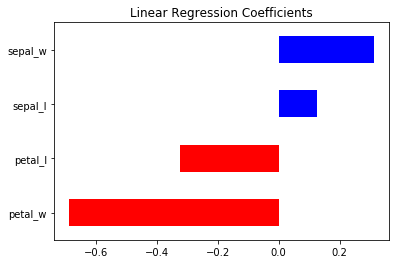

In [12]:
# -*- coding: utf-8 -*-
"""
Created on Thu Apr  4 19:51:21 2019

@author: litha
"""

import sklearn

# Create linear regression
regressor = sklearn.linear_model.LinearRegression()

# Fit/train linear regression
regressor.fit(x_train,y_train)
# Predict
pred = regressor.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

names = list(df.columns.values)
names.remove("species")

report_coef(
  names,
  regressor.coef_[:],
  regressor.intercept_,"Linear Regression Coefficients")

C:\Users\litha\Anaconda3\envs\Python36\lib\site-packages\matplotlib\pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)


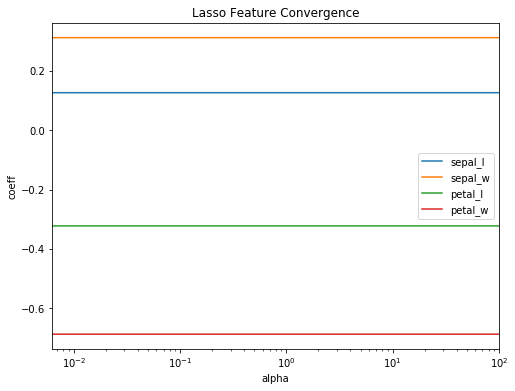

In [14]:
# -*- coding: utf-8 -*-
"""
Created on Thu Apr  4 19:54:06 2019

@author: litha
"""

import sklearn
import matplotlib.pyplot as plt
import numpy as np
#alphas = np.logspace(-8, 8, 10)
alphas = np.arange(0.,100,0.01)
coefarr = []
for alpha in alphas:
    # Create linear regression
    regressor = sklearn.linear_model.LinearRegression()
    
    # Fit/train LASSO
    regressor.fit(x_train,y_train)
    # Predict
    pred = regressor.predict(x_test)
    
    # Measure RMSE error.  RMSE is common for regression.
    score = np.sqrt(metrics.mean_squared_error(pred,y_test))
    #print("Final score (RMSE): {}".format(score))
    
    names = list(df.columns.values)
    names.remove("species")
    #print(alpha)
    coefarr.append(regressor.coef_.tolist())

#print(coefarr)
#print(np.array(coefarr)[:,0])

plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, np.array(coefarr)[:,0])
plt.semilogx(alphas, np.array(coefarr)[:,1])
plt.semilogx(alphas, np.array(coefarr)[:,2])
plt.semilogx(alphas, np.array(coefarr)[:,3])
# plot error lines showing +/- std. errors of the scores
#std_error = scores_std / np.sqrt(n_folds)

#plt.semilogx(alphas, scores + std_error, 'b--')
#plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
#plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
plt.title("Lasso Feature Convergence")
plt.ylabel('coeff')
plt.xlabel('alpha')
#plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])
plt.legend(names)

Final score (RMSE): 0.3835159242153168


,coef,positive
petal_l,-0.334076,False
sepal_l,-0.000000,True
sepal_w,-0.000000,True
petal_w,-0.000000,True


Intercept: 2.1361277103424072


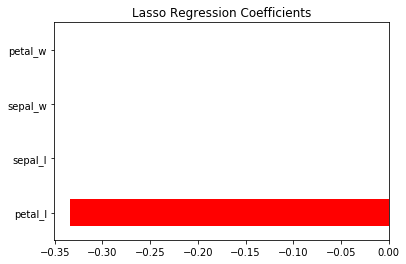

In [15]:
# -*- coding: utf-8 -*-
"""
Created on Thu Apr  4 19:54:06 2019

@author: litha
"""

import sklearn
from sklearn.linear_model import Lasso

# Create linear regression
regressor = Lasso(random_state=0,alpha=0.1)

# Fit/train LASSO
regressor.fit(x_train,y_train)
# Predict
pred = regressor.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

names = list(df.columns.values)
names.remove("species")
report_coef(
  names,
  regressor.coef_,
  regressor.intercept_,"Lasso Regression Coefficients")

C:\Users\litha\Anaconda3\envs\Python36\lib\site-packages\ipykernel_launcher.py:20: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
C:\Users\litha\Anaconda3\envs\Python36\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\litha\Anaconda3\envs\Python36\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7232575416564941, tolerance: 0.0018719997024163604
  positive)
C:\Users\litha\Anaconda3\envs\Python36\lib\site-packages\matplotlib\pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)


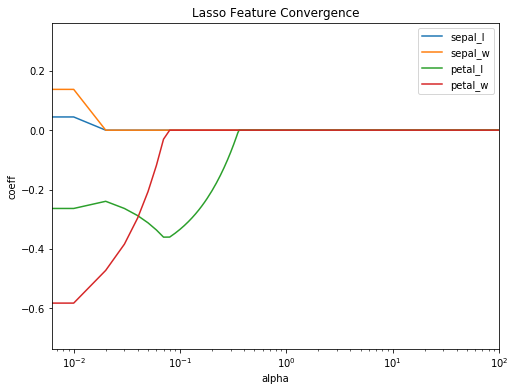

In [17]:
# -*- coding: utf-8 -*-
"""
Created on Thu Apr  4 19:54:06 2019

@author: litha
"""

import sklearn
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import numpy as np
#alphas = np.logspace(-8, 8, 10)
alphas = np.arange(0.,100,0.01)
coefarr = []
for alpha in alphas:
    # Create linear regression
    regressor = Lasso(random_state=0,alpha=alpha)
    
    # Fit/train LASSO
    regressor.fit(x_train,y_train)
    # Predict
    pred = regressor.predict(x_test)
    
    # Measure RMSE error.  RMSE is common for regression.
    score = np.sqrt(metrics.mean_squared_error(pred,y_test))
    #print("Final score (RMSE): {}".format(score))
    
    names = list(df.columns.values)
    names.remove("species")
    #print(alpha)
    coefarr.append(regressor.coef_.tolist())

#print(coefarr)
#print(np.array(coefarr)[:,0])

plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, np.array(coefarr)[:,0])
plt.semilogx(alphas, np.array(coefarr)[:,1])
plt.semilogx(alphas, np.array(coefarr)[:,2])
plt.semilogx(alphas, np.array(coefarr)[:,3])
# plot error lines showing +/- std. errors of the scores
#std_error = scores_std / np.sqrt(n_folds)

#plt.semilogx(alphas, scores + std_error, 'b--')
#plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
#plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
plt.title("Lasso Feature Convergence")
plt.ylabel('coeff')
plt.xlabel('alpha')
#plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])
plt.legend(names)

C:\Users\litha\Anaconda3\envs\Python36\lib\site-packages\sklearn\model_selection\_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\litha\Anaconda3\envs\Python36\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\litha\Anaconda3\envs\Python36\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5108561515808105, tolerance: 0.001212121220305562
  positive)
C:\Users\litha\Anaconda3\envs\Python36\lib\site-packages\sklearn\model_selection\_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  

[ 0.28785098  0.27773941  0.26225757 ... -0.0006825  -0.0006825
 -0.0006825 ]


C:\Users\litha\Anaconda3\envs\Python36\lib\site-packages\matplotlib\pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)


(0.006309604994325539, 99.99000000000001)

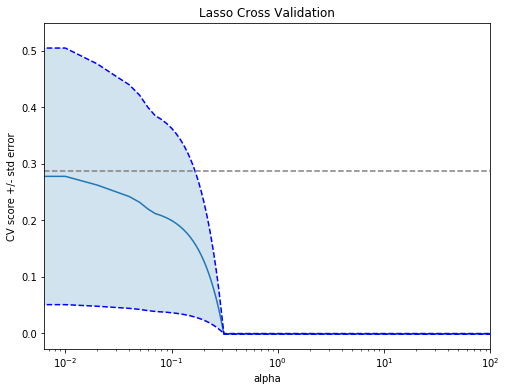

In [19]:
# -*- coding: utf-8 -*-
"""
Created on Thu Apr  4 19:55:48 2019

@author: litha
"""

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

lasso = Lasso(random_state=42)
#alphas = np.logspace(-8, 8, 10)
alphas = np.arange(0.,100,0.01)
scores = list()
scores_std = list()

n_folds = 3

for alpha in alphas:
    lasso.alpha = alpha
    this_scores = cross_val_score(lasso, x, y, cv=n_folds, n_jobs=1)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

scores, scores_std = np.array(scores), np.array(scores_std)

plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)
print (scores)
#print(std_error)
# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
plt.title("Lasso Cross Validation")
plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

Final score (RMSE): 0.5010436177253723


,coef,positive
petal_l,-0.002651,False
sepal_l,-0.001461,False
petal_w,-0.001433,False
sepal_w,-0.000449,False


Intercept: 0.5061070919036865


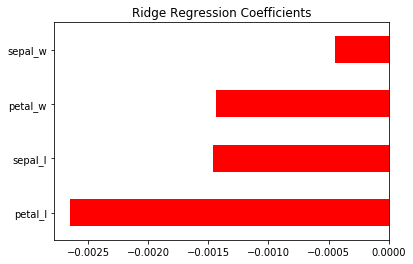

In [20]:
# -*- coding: utf-8 -*-
"""
Created on Thu Apr  4 19:56:51 2019

@author: litha
"""

import sklearn
from sklearn.linear_model import Ridge

# Create linear regression
regressor = Ridge(alpha=10000)

# Fit/train Ridge
regressor.fit(x_train,y_train)
# Predict
pred = regressor.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

names = list(df.columns.values)
names.remove("species")
report_coef(
  names,
  regressor.coef_[:],
  regressor.intercept_,"Ridge Regression Coefficients")

C:\Users\litha\Anaconda3\envs\Python36\lib\site-packages\matplotlib\pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)


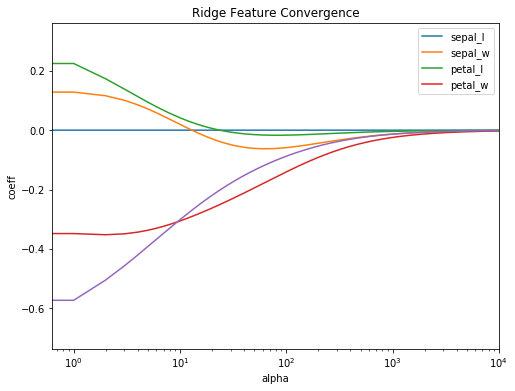

In [21]:
# -*- coding: utf-8 -*-
"""
Created on Thu Apr  4 19:54:06 2019

@author: litha
"""

import sklearn
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import numpy as np
#alphas = np.logspace(-8, 8, 10)
alphas = np.arange(0.,10000,1)
coefarr = []
for alpha in alphas:
    # Create linear regression
    regressor = Ridge(random_state=0,alpha=alpha)
    
    # Fit/train LASSO
    regressor.fit(x_train,y_train)
    # Predict
    pred = regressor.predict(x_test)
    
    # Measure RMSE error.  RMSE is common for regression.
    score = np.sqrt(metrics.mean_squared_error(pred,y_test))
    #print("Final score (RMSE): {}".format(score))
    
    names = list(df.columns.values)
    names.remove("species")
    #print(alpha)
    coefarr.append(regressor.coef_.tolist())

#print(coefarr)
#print(np.array(coefarr)[:,0])

plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, np.zeros(len(alphas)))
plt.semilogx(alphas, np.array(coefarr)[:,0])
plt.semilogx(alphas, np.array(coefarr)[:,1])
plt.semilogx(alphas, np.array(coefarr)[:,2])
plt.semilogx(alphas, np.array(coefarr)[:,3])
# plot error lines showing +/- std. errors of the scores
#std_error = scores_std / np.sqrt(n_folds)

#plt.semilogx(alphas, scores + std_error, 'b--')
#plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
#plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
plt.title("Ridge Feature Convergence")
plt.ylabel('coeff')
plt.xlabel('alpha')
#plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])
plt.legend(names)

[0.28785098 0.28439252 0.28033987 ... 0.00231341 0.0023131  0.00231282]


C:\Users\litha\Anaconda3\envs\Python36\lib\site-packages\matplotlib\pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)


(0.6309604994325533, 9999.0)

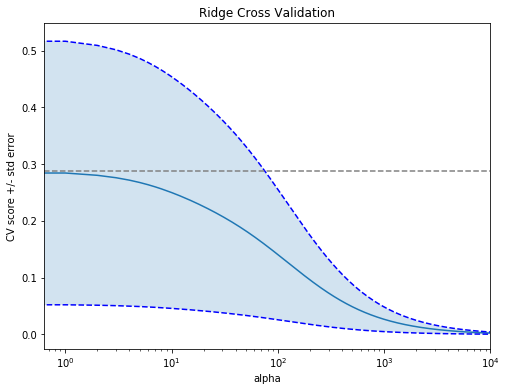

In [22]:
# -*- coding: utf-8 -*-
"""
Created on Thu Apr  4 19:55:48 2019

@author: litha
"""

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

ridge = Ridge(random_state=42)
#alphas = np.logspace(-8, 8, 10)
alphas = np.arange(0.,10000,1)
scores = list()
scores_std = list()

n_folds = 3

for alpha in alphas:
    ridge.alpha = alpha
    this_scores = cross_val_score(ridge, x, y, cv=n_folds, n_jobs=1)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

scores, scores_std = np.array(scores), np.array(scores_std)

plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)
print (scores)
#print(std_error)
plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
plt.title("Ridge Cross Validation")
plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

Final score (RMSE): 0.3496725857257843


,coef,positive
petal_w,-0.306505,False
petal_l,-0.288505,False
sepal_l,0.000000,True
sepal_w,0.000000,True


Intercept: 2.432499885559082


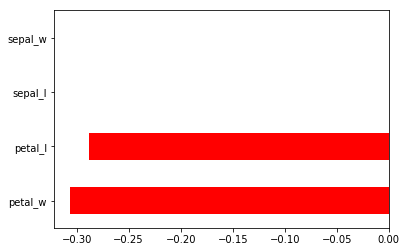

In [23]:
# -*- coding: utf-8 -*-
"""
Created on Thu Apr  4 19:59:44 2019

@author: litha
"""

import sklearn
from sklearn.linear_model import ElasticNet

# Create linear regression
regressor = ElasticNet(alpha=0.1, l1_ratio=0.1)

# Fit/train LASSO
regressor.fit(x_train,y_train)
# Predict
pred = regressor.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

names = list(df.columns.values)
names.remove("species")
report_coef(
  names,
  regressor.coef_,
  regressor.intercept_)

C:\Users\litha\Anaconda3\envs\Python36\lib\site-packages\ipykernel_launcher.py:20: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
C:\Users\litha\Anaconda3\envs\Python36\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\litha\Anaconda3\envs\Python36\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7232575416564941, tolerance: 0.0018719997024163604
  positive)
C:\Users\litha\Anaconda3\envs\Python36\lib\site-packages\matplotlib\pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)


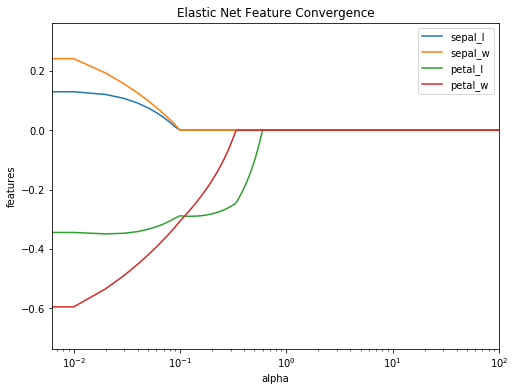

In [25]:
# -*- coding: utf-8 -*-
"""
Created on Thu Apr  4 19:54:06 2019

@author: litha
"""

import sklearn
from sklearn.linear_model import ElasticNet
import matplotlib.pyplot as plt
import numpy as np
#alphas = np.logspace(-8, 8, 10)
alphas = np.arange(0.,100,0.01)
coefarr = []
for alpha in alphas:
    # Create linear regression
    regressor = ElasticNet(alpha=alpha,l1_ratio=alpha)
    
    # Fit/train LASSO
    regressor.fit(x_train,y_train)
    # Predict
    pred = regressor.predict(x_test)
    
    # Measure RMSE error.  RMSE is common for regression.
    score = np.sqrt(metrics.mean_squared_error(pred,y_test))
    #print("Final score (RMSE): {}".format(score))
    
    names = list(df.columns.values)
    names.remove("species")
    #print(alpha)
    coefarr.append(regressor.coef_.tolist())

#print(coefarr)
#print(np.array(coefarr)[:,0])

plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, np.array(coefarr)[:,0])
plt.semilogx(alphas, np.array(coefarr)[:,1])
plt.semilogx(alphas, np.array(coefarr)[:,2])
plt.semilogx(alphas, np.array(coefarr)[:,3])
# plot error lines showing +/- std. errors of the scores
#std_error = scores_std / np.sqrt(n_folds)

#plt.semilogx(alphas, scores + std_error, 'b--')
#plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
#plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
plt.title("Elastic Net Feature Convergence")
plt.ylabel('features')
plt.xlabel('alpha')
#plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])
plt.legend(names)

C:\Users\litha\Anaconda3\envs\Python36\lib\site-packages\sklearn\model_selection\_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\litha\Anaconda3\envs\Python36\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\litha\Anaconda3\envs\Python36\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5108561515808105, tolerance: 0.001212121220305562
  positive)
C:\Users\litha\Anaconda3\envs\Python36\lib\site-packages\sklearn\model_selection\_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  

[ 0.28785098  0.28557857  0.28280751 ... -0.0006825  -0.0006825
 -0.0006825 ]
[0.23502934 0.23317392 0.23091136 ... 0.00055726 0.00055726 0.00055726]


C:\Users\litha\Anaconda3\envs\Python36\lib\site-packages\matplotlib\pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)


(0.006309604994325539, 99.99000000000001)

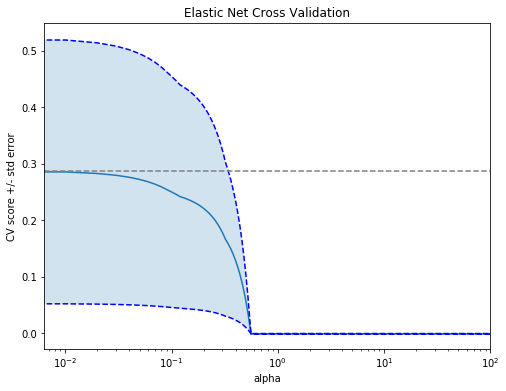

In [26]:
# -*- coding: utf-8 -*-
"""
Created on Thu Apr  4 19:55:48 2019

@author: litha
"""

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

elasticnet = ElasticNet(random_state=42)
#alphas = np.logspace(-8, 8, 10)
alphas = np.arange(0.,100,0.01)
scores = list()
scores_std = list()

n_folds = 3

for alpha in alphas:
    elasticnet.alpha = alpha
    elasticnet.l1_ratio = alpha
    this_scores = cross_val_score(elasticnet, x, y, cv=n_folds, n_jobs=1)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

scores, scores_std = np.array(scores), np.array(scores_std)

plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)
print (scores)
print(std_error)
plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
plt.title("Elastic Net Cross Validation")
plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])